In [1]:
import os
import mne
import numpy as np
import pandas as pd
import pyecap
from fnirs_functions import *

import matplotlib.pyplot as plt
import mne
from nilearn.plotting import plot_design_matrix

import mne_nirs
from mne_nirs.channels import get_long_channels, get_short_channels, picks_pair_to_idx
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

In [85]:
meta_index = 6

metaDF = pd.read_excel(r'M:\Projects\fNIRs_QC\20260206_0-1Hz_fNIRS\meta.xlsx')

tank = metaDF.at[meta_index, 'Tank']
flex_folder = metaDF.loc[meta_index, 'fNIRs Folder'] + '.mat'

fd = flexNIRs(flex_folder)
stim = pyecap.Stim(tank)
stimDF = stim.parameters
#fnirsDF = flex_import(flex_folder)

In [86]:
#Pass flexNIRs data to MNE
flex_data = fd.hemoDF_f.T
ch_names = ['S2_D2 HbO', 'S2_D2 HbR',
            'S1_D1 HbO', 'S2_D1 HbO','S1_D1 HbR','S2_D1 HbR',
            'S1_D3 HbO', 'S2_D3 HbO', 'S1_D3 HbR', 'S2_D3 HbR',]

ch_types = ['hbo', 'hbr',
            'hbo', 'hbo', 'hbr', 'hbr',
            'hbo', 'hbo', 'hbr', 'hbr']

In [87]:
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=fd.fs)
raw = mne.io.RawArray(flex_data, info, verbose=True)

Creating RawArray with float64 data, n_channels=10, n_times=77460
    Range : 0 ... 77459 =      0.000 ...   290.471 secs
Ready.


In [89]:
alignDF = stimDF.loc[stimDF['pulse amplitude (μA)'] < 0]
fd.manual_alignment(stimDF = alignDF, stim_start_index = int(61.5*266))
fd.plot_artifact(channel = 'D3 Ambient', show_stim = True)
#fd.stimDF

In [90]:
# Add stimulation annotations based on stimDF table
annot = mne.Annotations(
    onset = fd.stimDF['fNIRs onset time (s)'].to_list(),
    duration = fd.stimDF['duration (ms)'].mul(1e-3).to_list(),
    description = ['stim' for x in fd.stimDF.index]
)
raw.set_annotations(annot)

<RawArray | 10 x 77460 (290.5 s), ~5.9 MiB, data loaded>

In [91]:
raw_temp = raw.copy().resample(20)
long_ch = raw_temp.copy().drop_channels(['S2_D2 HbO', 'S2_D2 HbR'])
short_ch = raw_temp.copy().drop_channels(['S1_D1 HbO', 'S2_D1 HbO','S1_D1 HbR','S2_D1 HbR',
                              'S1_D3 HbO', 'S2_D3 HbO', 'S1_D3 HbR', 'S2_D3 HbR'])

In [101]:
design_matrix = make_first_level_design_matrix(long_ch, drift_model='polynomial', drift_order = 0, hrf_model ='spm',stim_dur=10)

In [102]:
design_matrix["ShortHbO"] = np.squeeze(short_ch.copy().pick(picks="hbo")._data)
design_matrix["ShortHbR"] = np.squeeze(short_ch.copy().pick(picks="hbr")._data)

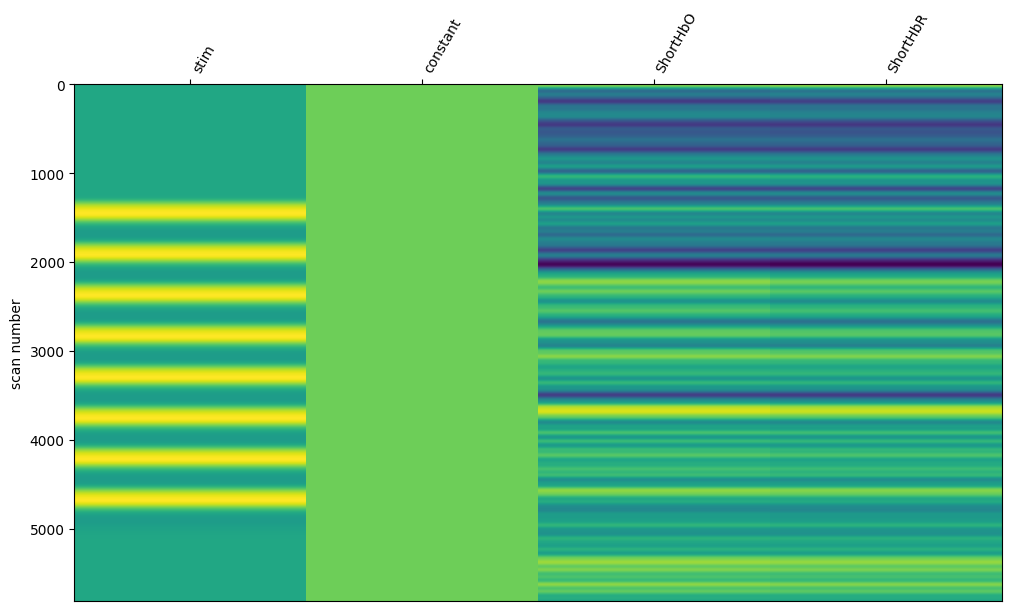

In [103]:
fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix, axes=ax1)

In [113]:
glm_est = run_glm(long_ch, design_matrix)

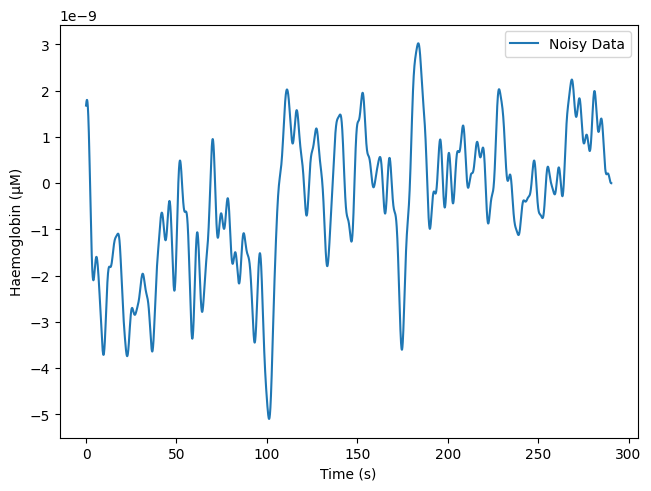

In [118]:
# First take a copy of noise free data for comparison

fig, ax = plt.subplots(constrained_layout=True)
#ax.plot(raw.times, raw_noise_free.get_data().T * 1e6)
#ax.plot(long_ch.times, long_ch.get_data(picks=['S1_D3 HbO']).T * 1e6, alpha=0.3)
ax.plot(long_ch.times, glm_est.theta()[0][0] * design_matrix["ShortHbO"].values * 1e6)
#ax.plot(long_ch.times, glm_est.theta()[1][0])# * design_matrix["stim"].values * 1e6)
ax.set(xlabel="Time (s)", ylabel="Haemoglobin (μM)")
ax.legend(["Noisy Data", "GLM Estimate"])

#print_results(glm_est, amp)

In [69]:
long_ch.get_data()

array([[ 7.09832935e-09,  7.34222044e-09,  7.58251530e-09, ...,
         7.94889076e-13, -1.34564929e-12,  6.79600140e-13],
       [ 7.06427642e-09,  7.30699748e-09,  7.54613957e-09, ...,
         7.91075741e-13, -1.33919379e-12,  6.76339883e-13],
       [-1.90524354e-07, -2.02394850e-07, -2.14380894e-07, ...,
        -2.66165099e-12,  7.00291789e-12,  2.23856972e-12],
       ...,
       [-1.43844732e-07, -1.48939315e-07, -1.54350268e-07, ...,
         6.07868372e-11, -4.15290429e-11,  5.98010965e-11],
       [-2.49160678e-07, -2.52837392e-07, -2.56668589e-07, ...,
         1.61541511e-11, -1.38006764e-11,  2.02827205e-11],
       [-1.79395929e-07, -1.83649729e-07, -1.88115120e-07, ...,
         8.50897834e-12, -3.21875538e-11,  2.77756575e-11]],
      shape=(8, 6089))

In [76]:
x = glm_est.theta()

<Axes: xlabel='Condition', ylabel='Theta'>

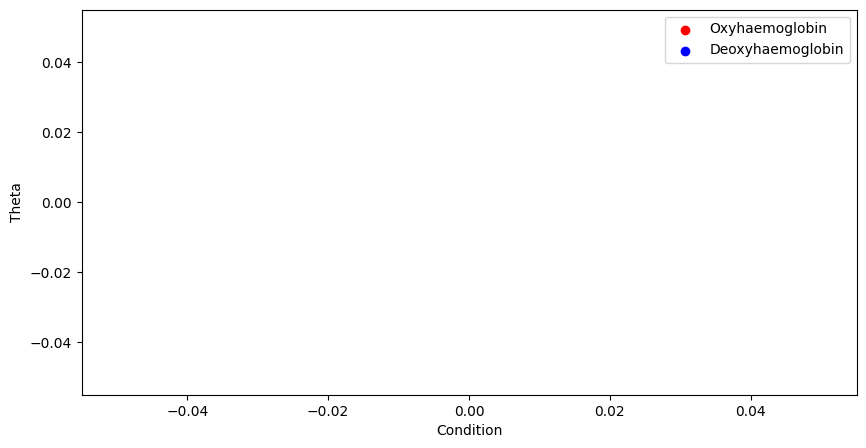

In [78]:
glm_est.scatter()